#  Прогнозирование заказов такси

## ОГЛАВЛЕНИЕ

[Описание проекта](#description)

[Цель проекта](#purpose)

[1. Изучение общей информации](#1)

[2. Подготовка данных](#2)

[3. Анализ данных](#3)

[4. Подготовка к обучению](#4)

- [3.1 Создание признаков](#4.1)

- [3.2 Деление на выборки](#4.2)

[5. Обучение моделей](#5)

- [5.1 Линейная регрессия](#5.1)

- [5.2 Решающее дерево](#5.2)

- [5.3 Случайный лес](#5.3)

- [5.4 LightGBM](#5.4)

[6. Сравнение моделей](#6)

[Общий вывод](#final)

<a id='description'></a>
## Описание проекта

Компания оператор такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.  

Данные лежат в файле taxi.csv, количество заказов находится в столбце 'num_orders'.

<a id='purpose'></a>
## Цель проекта

Нужно построить модель, предсказывающую количество заказов такси на следующий час. Для этого опробуем несколько моделей с различными гиперпараметрами и выберем лучшую. Целевой показатель - значение метрики RMSE на тестовой выборке должно быть не больше 48.

<a id='1'></a>
## Изучение общей информации

In [1]:
#Импортируем нужные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor
import lightgbm as lgb


In [2]:
#Прочитаем датасет
data = pd.read_csv('/datasets/taxi.csv')

In [3]:
#Выведем рандомные 10 строк таблицы для знакомства с данными
data.sample(10, random_state=12345)

,datetime,num_orders
13715,2018-06-04 05:50:00,5
21230,2018-07-26 10:20:00,24
21144,2018-07-25 20:00:00,20
9329,2018-05-04 18:50:00,9
10434,2018-05-12 11:00:00,18
20139,2018-07-18 20:30:00,17
22117,2018-08-01 14:10:00,15
8652,2018-04-30 02:00:00,14
4644,2018-04-02 06:00:00,5
11862,2018-05-22 09:00:00,12


In [4]:
#Выведем общую информацию для оценки количества пропусков и типов данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
#Посмотрим описательную статистику для количества заказов
data['num_orders'].describe()

count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64

**Вывод:**
1. Датаесет содержит 26496 в двух столбцах: время (datetime), количество заказов (num_orders).
2. Пропусков нет, минимальные и максимальные значения в количестве заказов выглядят правдоподобно.
2. Данные в столбце datetime имеют некорректный формат, нужно привести к формату datetime.


<a id='2'></a>
## Подготовка данных

In [6]:
#Изменим тип данных в колонке с датами
data['datetime'] = pd.to_datetime(data['datetime'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null datetime64[ns]
num_orders    26496 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [7]:
#Установим колонку с датами в качестве индекса и отсортируем по порядку
data.set_index('datetime', inplace = True)
data.sort_index(inplace=True)

print('Даты расположены по порядку:', data.index.is_monotonic)

Даты расположены по порядку: True


Так как данные необходимо предсказывать на следующий час, проведем ресемплирование по одному часу. Агрегировать данные будем суммированием, т.к. нужно общее количество заказов за период.

In [8]:
data = data.resample('1H').sum()
display(data.head())
display(data.info())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


None

**Вывод.** Изменили тип данных на формат даты. Провели ресемплирование данных по часу. Теперь видим, что имеем дело с интервалом с 01.03.2018 по 31.08.2018

<a id='3'></a>
## Анализ данных

In [9]:
#Построим график для визуализации данных, напишем функцию для вывода
def timeplot(data):
    data.plot(figsize=(16,10))
    plt.title("Количество заказов такси по часам", fontsize = 18)
    plt.ylabel("количество заказов", fontsize = 14)
    plt.xlabel("время", fontsize = 14) 
    plt.show()    

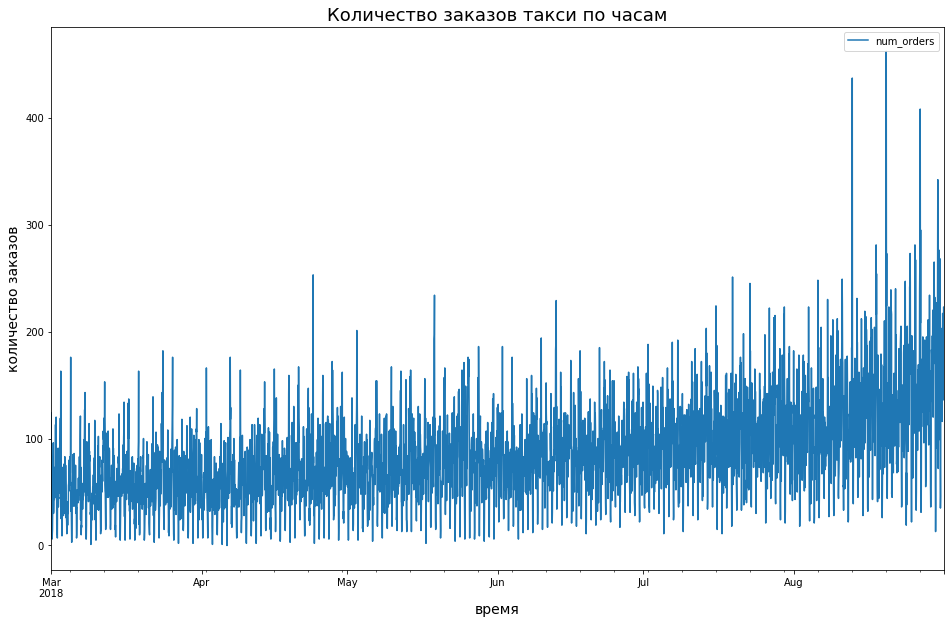

In [10]:
timeplot(data)

Для лучшего понимания временного ряда изучим тренды и сезонность.

In [11]:
#Разложим временной ряд на составляющие и выведем на графики
decomposed = seasonal_decompose(data)

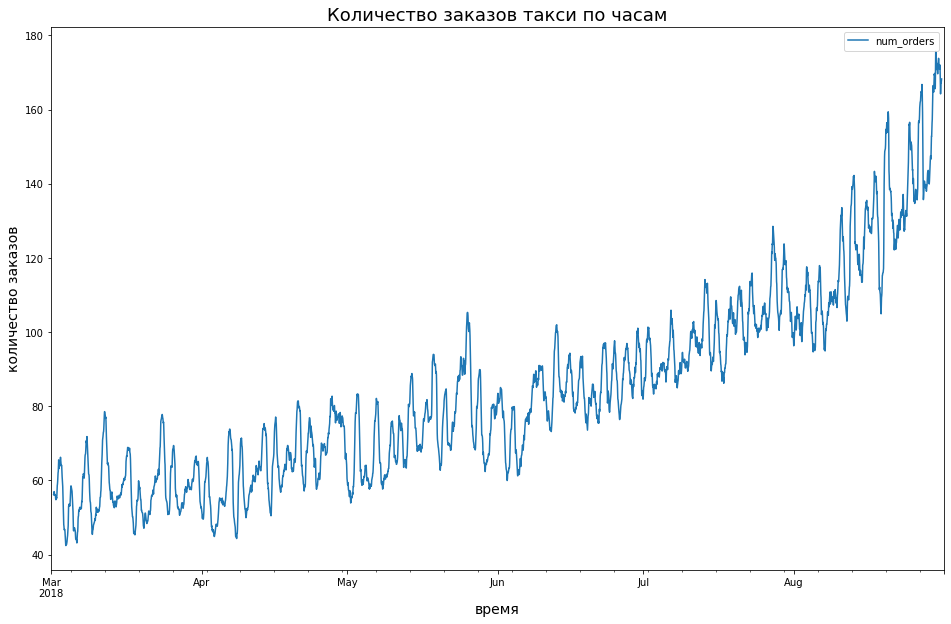

In [12]:
#График тренда
timeplot(decomposed.trend)

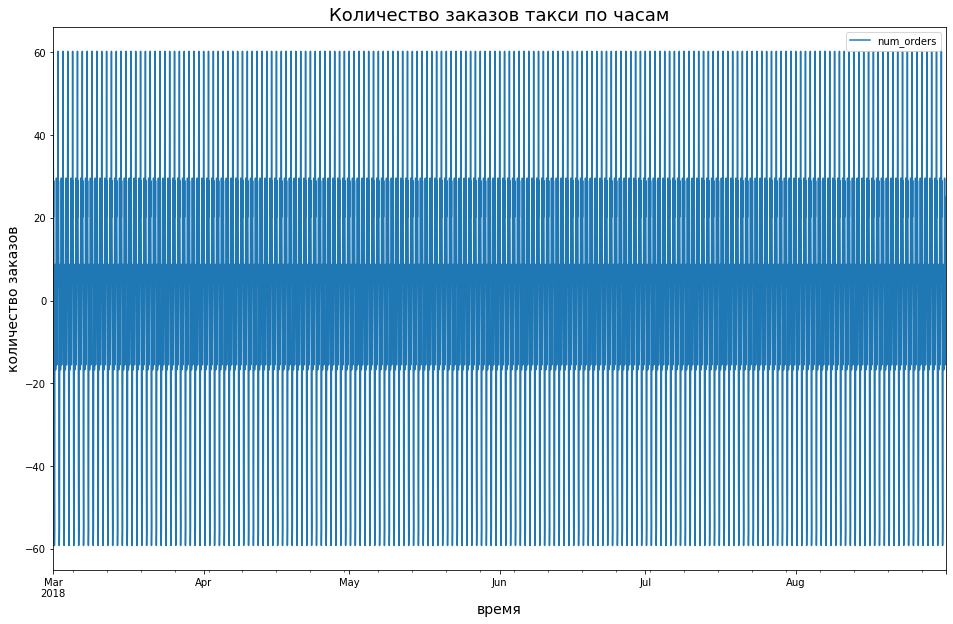

In [13]:
#График сезонности
timeplot(decomposed.seasonal)

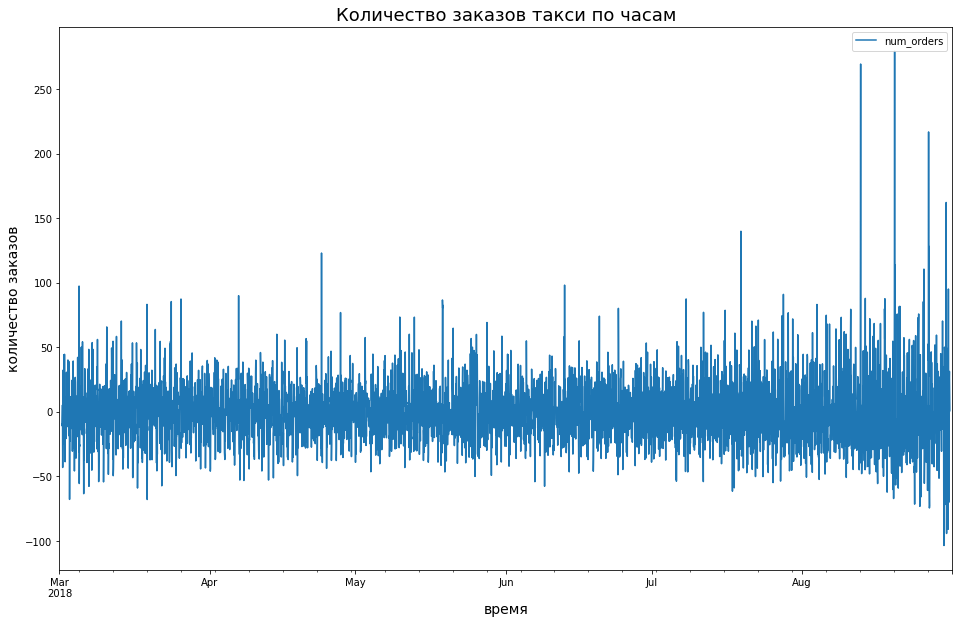

In [14]:
#График шумов
timeplot(decomposed.resid)

Видим на графике растущий тренд, то есть, количество заказов со временем увеличивается. Два других графика неинформативны, поэтому повторим вывод для более короткого отрезка времени - возьмем последний месяц

In [15]:
decomposed_month = seasonal_decompose(data['2018-08-01':'2018-08-31'])

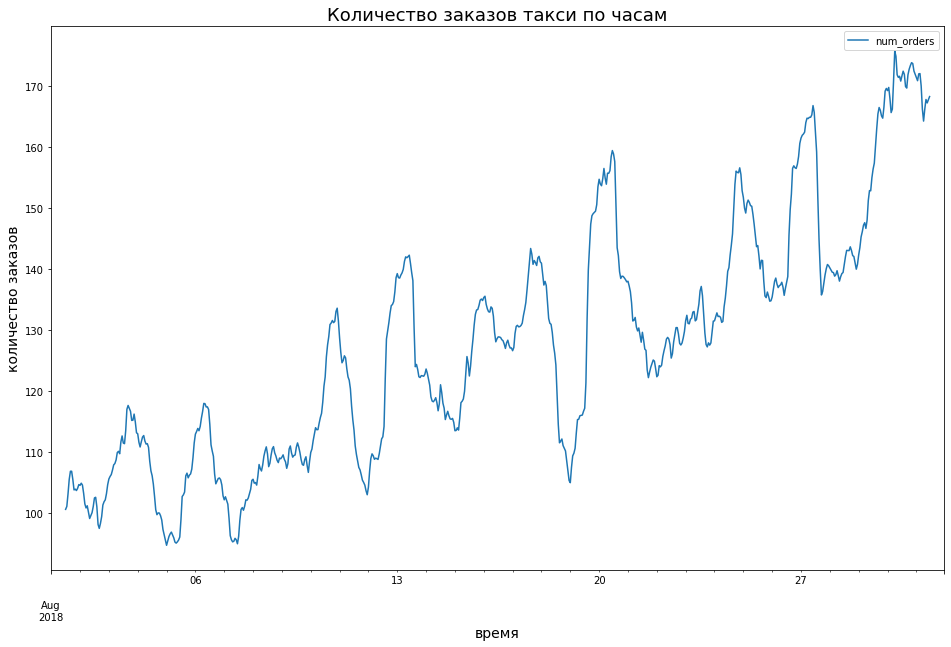

In [16]:
#График тренда
timeplot(decomposed_month.trend)

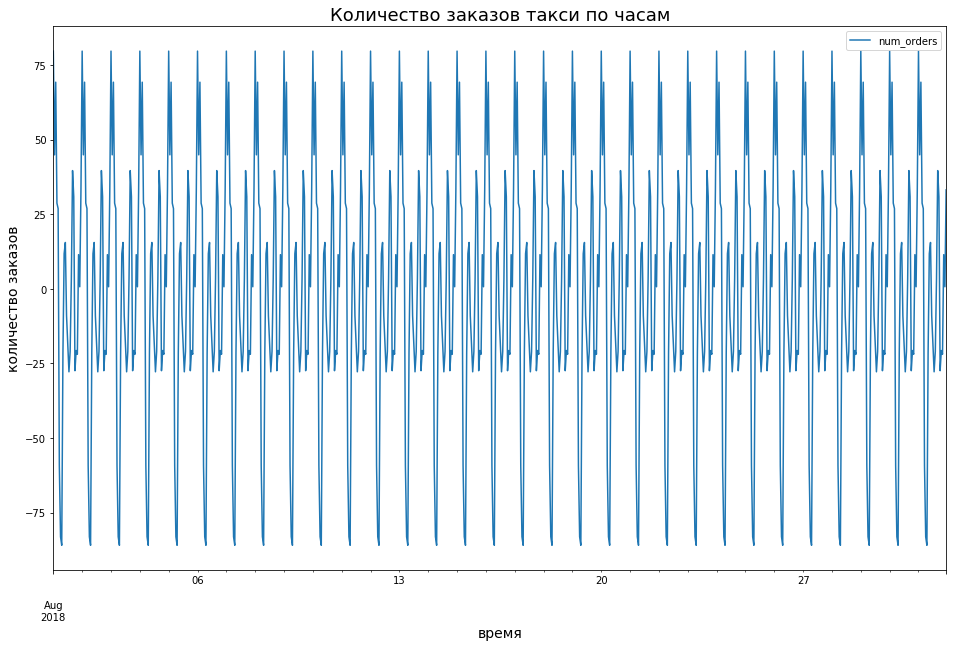

In [17]:
#График сезонности
timeplot(decomposed_month.seasonal)

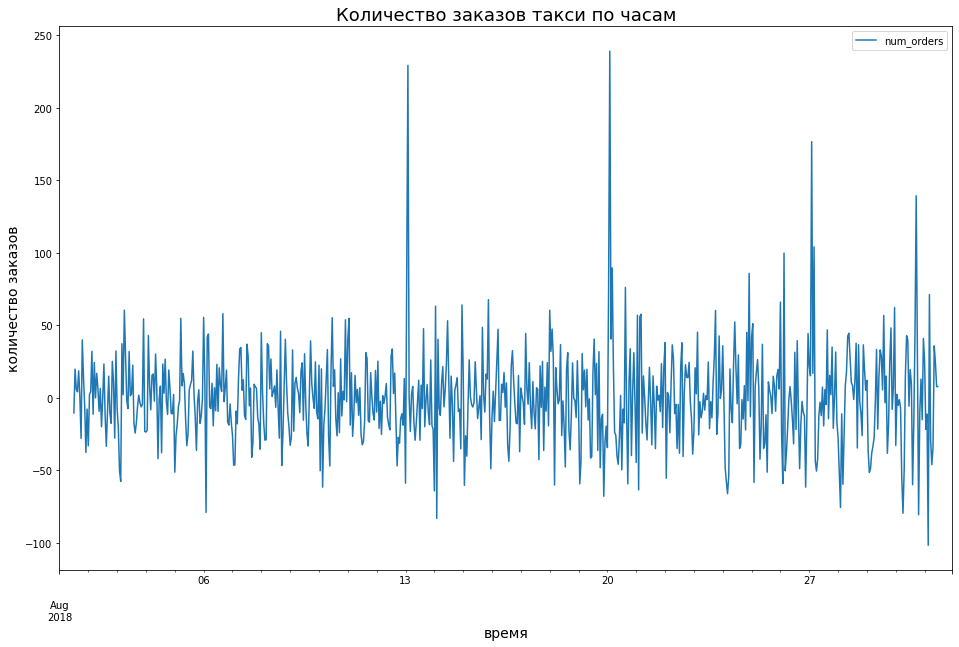

In [18]:
#График шумов
timeplot(decomposed_month.resid)

Дополнительно рассмотрим графики за один день, чтобы оценить изменение количества заказов по часам

In [19]:
decomposed_day = seasonal_decompose(data['2018-08-30':'2018-08-31'])

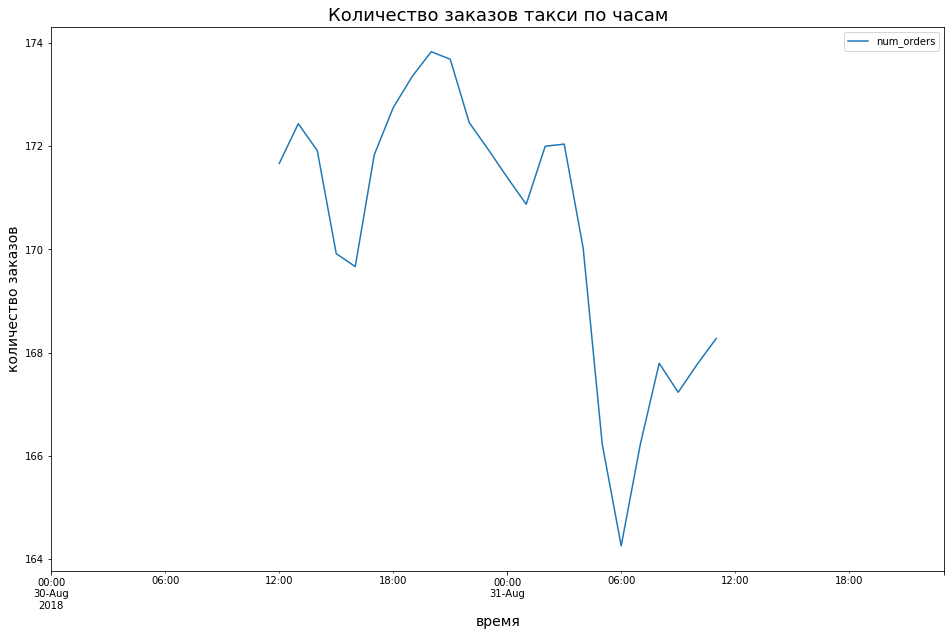

In [20]:
#График тренда
timeplot(decomposed_day.trend)

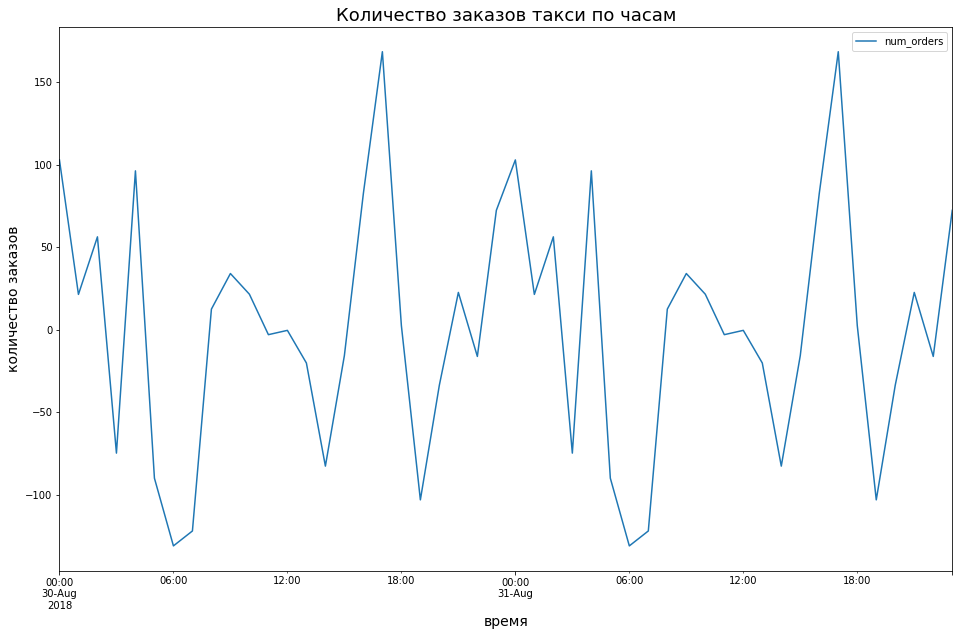

In [21]:
#График сезонности
timeplot(decomposed_day.seasonal)

Графики показывают, что существует тренд на увеличение количества заказов такси (но возможно это связано с тем, что данные у нас только за весну и лето, а летом рейсов очевидно больше, поскольку это традиционная пора отпусков). Также мы можем наблюдать определенную сезонность: по дням (выходные и начало недели), время дня (пики вечером и ночью, рано утром - спад), все это также закономерно можно связать с количеством рейсов и доступностью альтернативного транспорта (аэроэкспресс) в разные дни и часы. Сезонность и тренды по месяцам не можем оценить корректно, так как у нас имеются данные только за полгода.  

Так как мы отчетливо видим на графиках меняющийся тренд и, соответственно, растущее среднее значение, данный временной ряд не является стационарным. Поэтому потребуется ввести разности временного ряда, чтобы упростить задачу прогнозирования.

Также для обучения моделей нам понадобится ввести признаки dayofweek и hour, так как по ним была замечена сезонность.

<a id='4'></a>
## Подготовка к обучению

<a id='4.1'></a>
### Создание признаков

Будем добавлять признаки dayofweek и hour. Лаг предлагаю взять за 1 (т.е. значение из предыдущего часа), а скользящее среднее за 24 (по числу часов в сутках)

In [22]:
#Создадим функцию для добавления признаков
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data, 1, 24)
data = data.dropna()
data.head()

,num_orders,hour,dayofweek,lag_1,rolling_mean
datetime,,,,,
2018-03-02 00:00:00,90,0,4,58.0,56.833333
2018-03-02 01:00:00,120,1,4,90.0,55.416667
2018-03-02 02:00:00,75,2,4,120.0,56.875000
2018-03-02 03:00:00,64,3,4,75.0,57.041667
2018-03-02 04:00:00,20,4,4,64.0,56.958333


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 5 columns):
num_orders      4392 non-null int64
hour            4392 non-null int64
dayofweek       4392 non-null int64
lag_1           4392 non-null float64
rolling_mean    4392 non-null float64
dtypes: float64(2), int64(3)
memory usage: 205.9 KB


<a id='4.2'></a>
### Деление на выборки

In [24]:
#Выделим целевой признак и остальные для исходного датасета
target = data['num_orders']
features = data.drop('num_orders', axis=1)

In [25]:
#Отделим 90% для обучающей выборки
features_train, features_test, target_train, target_test = train_test_split(features, target, train_size=0.9, shuffle=False)

In [26]:
#Проверим правильность разбиения
print(features_train.shape, features_train.index.min(), features_train.index.max())
print(features_test.shape, features_test.index.min(), features_test.index.max())


(3952, 4) 2018-03-02 00:00:00 2018-08-13 15:00:00
(440, 4) 2018-08-13 16:00:00 2018-08-31 23:00:00


<a id='5'></a>
## Обучение моделей

<a id='5.1'></a>
### Линейная регрессия

In [27]:
%%time

lr = LinearRegression()
lr.fit(features_train, target_train)

CPU times: user 3.56 ms, sys: 408 µs, total: 3.96 ms
Wall time: 2.89 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [28]:
%%time
predictions_lr = lr.predict(features_test)
print("RMSE линейной регрессии: ", mean_squared_error(target_test, predictions_lr)**(0.5))

RMSE линейной регрессии:  51.22000101433688
CPU times: user 2.45 ms, sys: 0 ns, total: 2.45 ms
Wall time: 1.96 ms


<a id='5.2'></a>
### Решающее дерево

In [29]:
tscv = TimeSeriesSplit(n_splits=8)

In [30]:
#Подберем лучшие гиперпараметры
params_dtr = {
   'max_depth': range(1, 50),
   'min_samples_split': range(2, 20), 
   'min_samples_leaf': range(1, 5)
   }


dtr = DecisionTreeRegressor()
grid_dtr = GridSearchCV(estimator=dtr, param_grid=params_dtr, cv=tscv, scoring='neg_mean_squared_error')
grid_dtr.fit(features_train, target_train)

print("Лучшие гиперпараметры: ", grid_dtr.best_params_)

Лучшие гиперпараметры:  {'max_depth': 13, 'min_samples_leaf': 4, 'min_samples_split': 19}


In [31]:
%%time
dtr_best = DecisionTreeRegressor(max_depth=13, min_samples_split=19, min_samples_leaf=4, random_state=12345)
dtr_best.fit(features_train, target_train)

CPU times: user 7.43 ms, sys: 4 ms, total: 11.4 ms
Wall time: 9.88 ms


DecisionTreeRegressor(criterion='mse', max_depth=13, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=19, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=12345, splitter='best')

In [32]:
%%time
predictions_dtr_best = dtr_best.predict(features_test)
print("RMSE решающего дерева: ", (mean_squared_error(target_test, predictions_dtr_best))**(0.5))

RMSE решающего дерева:  49.88270432713761
CPU times: user 2.2 ms, sys: 0 ns, total: 2.2 ms
Wall time: 1.88 ms


<a id='5.3'></a>
### Случайный лес

In [36]:
#Подберем лучшие гиперпараметры
params_rfr = {
   'max_depth': range(1, 50),
   'min_samples_split': [2, 5, 10, 20], 
   'n_estimators': [80, 100, 150, 200]
   }


rfr = RandomForestRegressor()
grid_rfr = GridSearchCV(estimator=rfr, param_grid=params_rfr, cv=tscv, scoring='neg_mean_squared_error')
grid_rfr.fit(features_train, target_train)


print("Лучшие гиперпараметры: ", grid_rfr.best_params_)

Лучшие гиперпараметры:  {'max_depth': 34, 'min_samples_split': 20, 'n_estimators': 80}


In [39]:
%%time
rfr_best = RandomForestRegressor(max_depth=34, min_samples_split=20, n_estimators=80, random_state=12345)
rfr_best.fit(features_train, target_train)

CPU times: user 442 ms, sys: 7 µs, total: 442 ms
Wall time: 440 ms


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=34,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=20,
                      min_weight_fraction_leaf=0.0, n_estimators=80,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [40]:
%%time
predictions_rfr_best = rfr_best.predict(features_test)
print("RMSE случайного леса: ", (mean_squared_error(target_test, predictions_rfr_best))**(0.5))

RMSE случайного леса:  45.737169522232556
CPU times: user 10.8 ms, sys: 0 ns, total: 10.8 ms
Wall time: 9.39 ms


<a id='5.4'></a>
### LightGBM

In [41]:
#Подберем лучшие гиперпараметры
params_light = {
   'num_leaves': [10, 20, 30, 70],
   'max_depth': range(-5, -1),
   'n_estimators':[80, 100, 150]
   }

light = LGBMRegressor()
grid_light = GridSearchCV(estimator=light, param_grid=params_light, cv=tscv, scoring='neg_mean_squared_error')
grid_light.fit(features_train, target_train)

print("Лучшие гиперпараметры: ", grid_light.best_params_)

Лучшие гиперпараметры:  {'max_depth': -5, 'n_estimators': 80, 'num_leaves': 20}


In [42]:
%%time
light_best = LGBMRegressor(num_leaves=20, max_depth=-5, n_estimators=80)
light_best.fit(features_train, target_train)

CPU times: user 3.82 s, sys: 17.9 ms, total: 3.84 s
Wall time: 3.9 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-5,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=80, n_jobs=-1, num_leaves=20, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [43]:
%%time
predictions_light_best = light_best.predict(features_test)
print("RMSE LightGBM: ", (mean_squared_error(target_test, predictions_light_best))**(0.5))

RMSE LightGBM:  43.100210009067546
CPU times: user 42.4 ms, sys: 3.74 ms, total: 46.1 ms
Wall time: 92.2 ms


<a id='6'></a>
## Сравнение моделей

Выведем итоговую сравнительную таблицу для всех рассмотренных моделей

In [44]:
#Итоговая таблица сравнения моделей 
data = [["2.63 ms", "5.1 ms", 51.22],
        ["9.09 ms", "2.68 ms", 49.88],
        ["515 ms", "8.75 ms", 45.73],
        ["736 ms", "8.89 ms", 43.1]]
model = ["Линейная регрессия", "Решающее дерево", "Случайный лес", "LightGBM"]

pd.DataFrame(data=data, index=model, columns=["Время обучения", "Время предсказания", "RMSE"])

,Время обучения,Время предсказания,RMSE
Линейная регрессия,2.63 ms,5.1 ms,51.22
Решающее дерево,9.09 ms,2.68 ms,49.88
Случайный лес,515 ms,8.75 ms,45.73
LightGBM,736 ms,8.89 ms,43.10


Пороговое значение RMSE = 48, заданное в условиях проекта, преодолели две модели Случайный лес (RMSE = 45.17) и LightGBM (RMSE = 43.1), вторая побеждает и по качеству, и по скорости. Дополнительно выведем для обеих моделей графики сравнения полученных предсказания и фактических значений таргета.

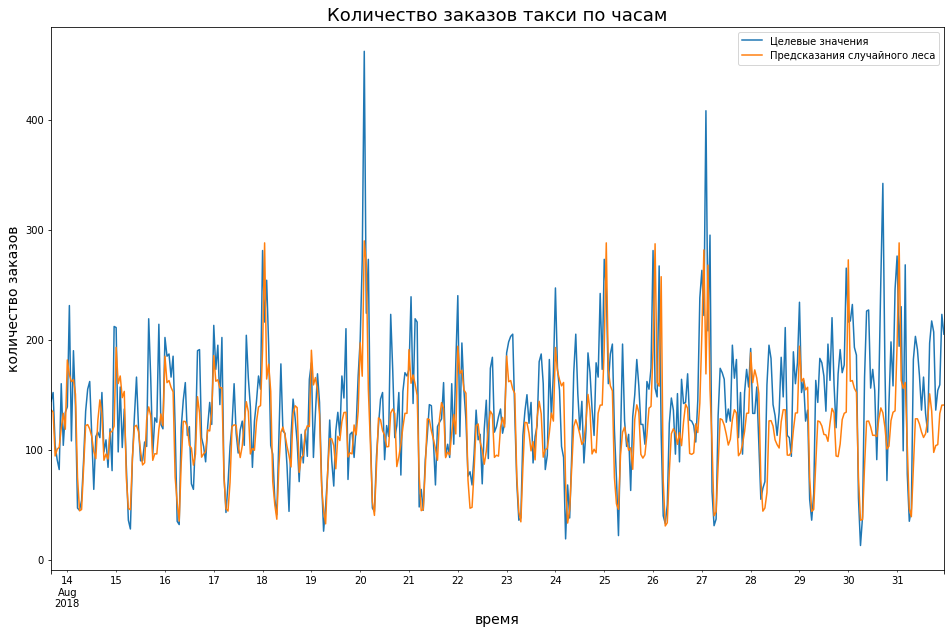

In [68]:
#Выведем сравнительный график для случайного леса за весь период
frame_rfr = {'Целевые значения':target_test, 'Предсказания случайного леса':predictions_rfr_best}
result_rfr = pd.DataFrame(frame)
timeplot(result_rfr)

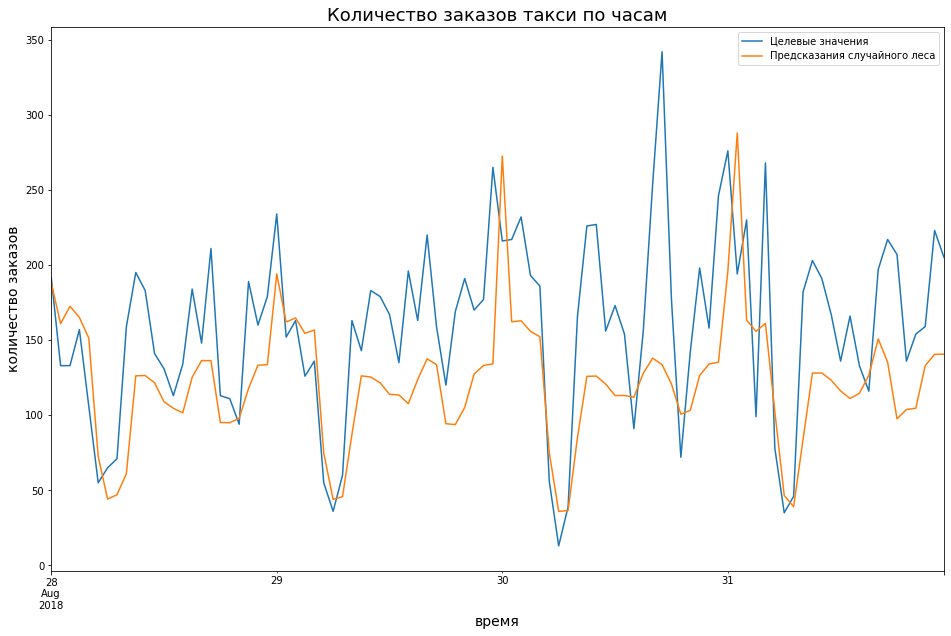

In [69]:
#Выведем сравнительный график для случайного леса за случайные три дня
timeplot(result_rfr['2018-08-28':'2018-08-31'])

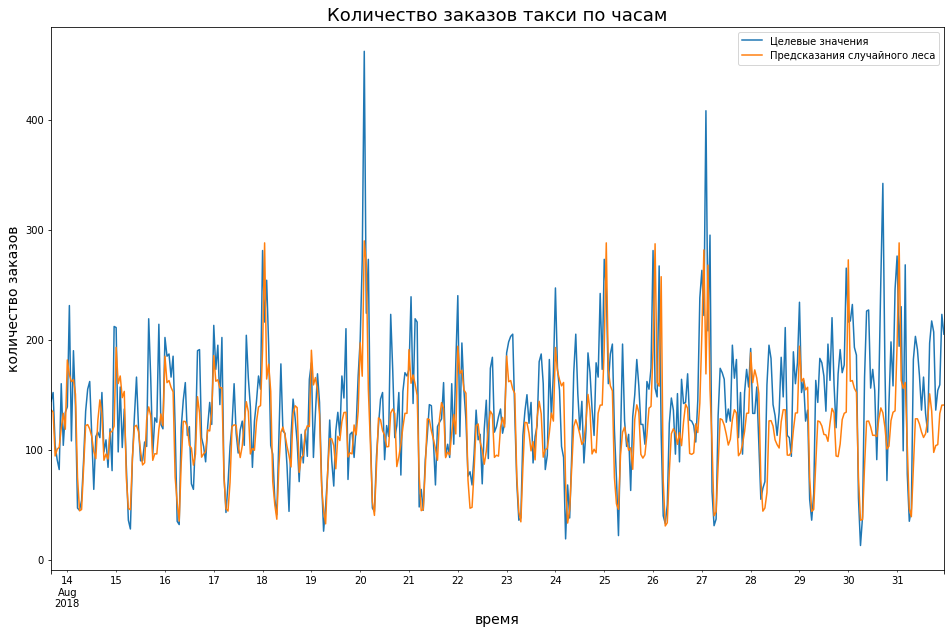

In [71]:
#Выведем сравнительный график для LightGBM за весь период
frame_light = {'Целевые значения':target_test, 'Предсказания LightGBM':predictions_light_best}
result_light = pd.DataFrame(frame)
timeplot(result_light)

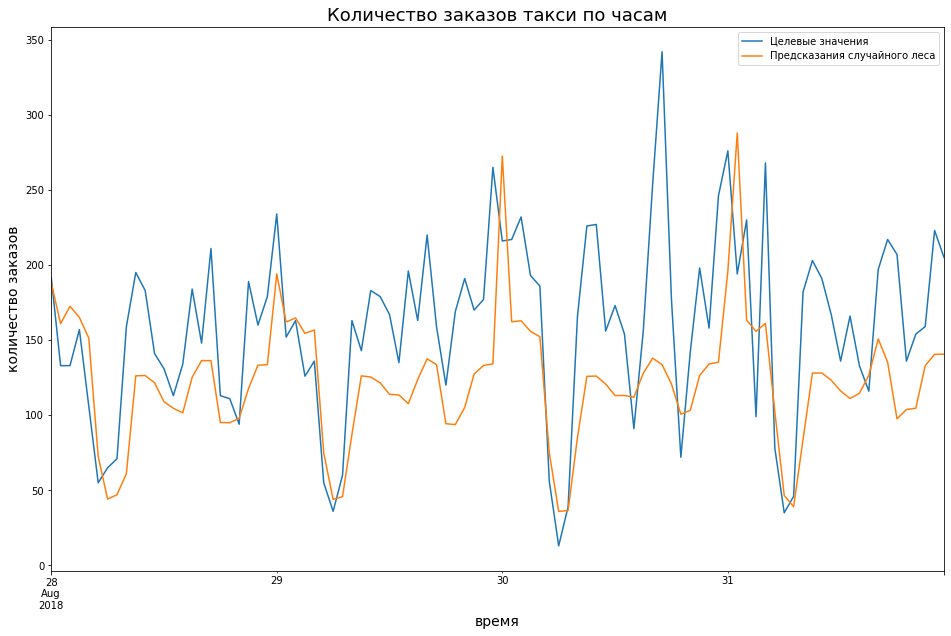

In [72]:
#Выведем сравнительный график для LightGBM за случайные три дня
timeplot(result_light['2018-08-28':'2018-08-31'])

По графикам видим, что обе лучшие модели дают примерно похожую картину предсказаний. В целом линии графиков факта и предсказаний довольно близки друг к другу. Можно сказать, что обе модели неплохо прогнозируют, однако у них наблюдается общая проблема - предсказания тяготеют к медиане, значительно не дотягивая до факта на пиках. Так как заказчик хотел увеличить количество автомобилей такси именно в периоды максимальных нагрузок, получается, что полученные предсказания не вполне отвечают заданной цели. По результатам исследования оставляем лучшую модель - LightGBM, однако рекомендуется дорабатывать ее.  

Плюс, стоит отметить, что исследовались данные только за несколько месяцев, из-за этого мы не видим полной картины по сезонности (например, зимой, которой нет в датасете, количество заказов может сильно снизиться из-за меньшего количества отпусков). В идеале лучше исследовать более длительный период (несколько лет), вероятно это поможет повысить точность прогноза.

<a id='final'></a>
## Вывод

Для компании под задачу прогнозирования количества заказов такси в периоды пиковой нагрузки рекомендуется модель градиентного бустинга LightGBM, метрика качества RMSE для нее составляет 43.1, что ниже заказанного по условию проекта минимума 48.